In [1]:
########## 0 - Importing relevant libraries
import h5py
import sklearn
import matplotlib.pyplot as plt

from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint

import numpy as np
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout 
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D 
from keras import initializers
from keras import regularizers , optimizers
import scipy.io as sio

Using TensorFlow backend.


In [6]:
###############  1 - LOADING PORTION OF TRAINING AND DEV SET ############### 
## loading training set
train = h5py.File('/floyd/input/echogrampreprocessed/EchogramPreprocessed.mat','r')
label_train = np.array(train['label'])
X_train = np.array(train['EchogramWithBottom'])

In [8]:
## 1.2 - Resizing the training set, 
# in fact there is too many pings ~2.3 million it won't fit into memorynp.random.seed(7)
m,_ = X_train.shape
index = np.random.choice(m,500000,replace=False)
label_train = label_train[index,:]
X_train = X_train[index,:]

In [9]:
## 1.3 - Preprocessing step
# Replacing Nan with -200
X_train = np.add(np.nan_to_num(X_train),np.isnan(X_train) * -200)

In [2]:
## 1.4 - loading development set
dev = sio.loadmat('/floyd/input/devset/EchogramDev.mat')
X_dev = np.array(dev['Echogram'])
label_dev = np.array(dev['label'])

# Replacing Nan with -200
X_dev = np.add(np.nan_to_num(X_dev), np.isnan(X_dev) * -200)

In [10]:
############### 2 - RESHAPE THE TWO DATASETS  ############### 
##  Reshaping the data to feed the convolutional neural network
m_train,n = X_train.shape
m_dev,n = X_dev.shape
X_train = X_train.reshape(m_train,n,1)
X_dev = X_dev.reshape(m_dev,n,1)

Y_train = to_categorical(label_train)
Y_train = Y_train[:,1:]

Y_dev =  to_categorical(label_dev)
Y_dev =  Y_dev[:,1:]

In [15]:
############### 3 - DEFINING OUR MODEL ############### 
def variable_CNN(kernel_1, kernel_2, kernel_3, no_unit1, no_unit2, no_unit3, dropout1, dropout2):
    # create model
    model = Sequential()
    ## 1st Conv Layer
    model.add(Conv1D(input_shape=[2550,1], filters=1, kernel_size=kernel_1, strides=2, activation='selu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling1D(pool_size=kernel_1, strides=1, padding='valid'))  
    ## 2nd Conv Layer
    model.add(Conv1D(filters=1, kernel_size=kernel_2, strides=1, activation='selu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling1D(pool_size=kernel_2, strides=1, padding='valid')) 
    ## 3rd Conv Layer
    model.add(Conv1D(filters=1, kernel_size=kernel_3, strides=1, activation='selu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling1D(pool_size=kernel_3, strides=1, padding='valid')) 
    model.add(Flatten())
    model.add(Dropout(dropout1))
    model.add(Dense(no_unit1,kernel_initializer="normal", bias_initializer='zeros', activation='selu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(dropout2))
    model.add(Dense(no_unit2,kernel_initializer="normal", bias_initializer='zeros', activation='selu', kernel_constraint=maxnorm(3)))
    model.add(Dense(no_unit3,kernel_initializer="normal", bias_initializer='zeros', activation='selu', kernel_constraint=maxnorm(3)))
    model.add(Dense(2, kernel_initializer="normal", bias_initializer='zeros', activation='sigmoid')) 
    # Custom optimizer
	# Compile model
    model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model 

In [13]:
vcnn = variable_CNN(56, 54, 13,303, 202,  81, 0.5, 0.6)
vcnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 1248, 1)           57        
_________________________________________________________________
batch_normalization_4 (Batch (None, 1248, 1)           4         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1193, 1)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1140, 1)           55        
_________________________________________________________________
batch_normalization_5 (Batch (None, 1140, 1)           4         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1087, 1)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1075, 1)           14        
__________

In [16]:
%%time
filepath="BasicNN_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = vcnn.fit(X_train, Y_train, epochs = 50, validation_data=(X_dev,Y_dev), callbacks=callbacks_list, batch_size = 8192, shuffle=True)

Train on 500000 samples, validate on 100000 samples
Epoch 1/50
500000/500000 [==============================] - 83s 166us/step - loss: 0.2731 - acc: 0.8821 - val_loss: 0.1230 - val_acc: 0.9267

Epoch 00001: val_acc improved from -inf to 0.92674, saving model to BasicNN_weights.hdf5
Epoch 2/50
500000/500000 [==============================] - 33s 67us/step - loss: 0.1836 - acc: 0.9082 - val_loss: 0.1009 - val_acc: 0.9399

Epoch 00002: val_acc improved from 0.92674 to 0.93994, saving model to BasicNN_weights.hdf5
Epoch 3/50
500000/500000 [==============================] - 33s 67us/step - loss: 0.1803 - acc: 0.9116 - val_loss: 0.1063 - val_acc: 0.9402

Epoch 00003: val_acc improved from 0.93994 to 0.94025, saving model to BasicNN_weights.hdf5
Epoch 4/50
500000/500000 [==============================] - 33s 67us/step - loss: 0.1782 - acc: 0.9134 - val_loss: 0.1079 - val_acc: 0.9444

Epoch 00004: val_acc improved from 0.94025 to 0.94437, saving model to BasicNN_weights.hdf5
Epoch 5/50
500000/

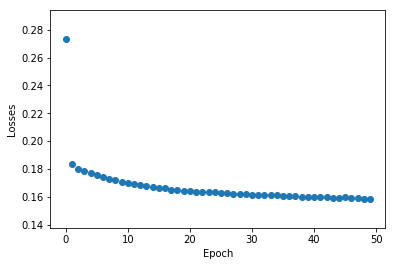

In [17]:
############### 4 - RESULTS ############### 
## Diagnosing the learning phase
losses = history.history["loss"]
epoch = history.epoch
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.scatter(epoch, losses)
plt.show()

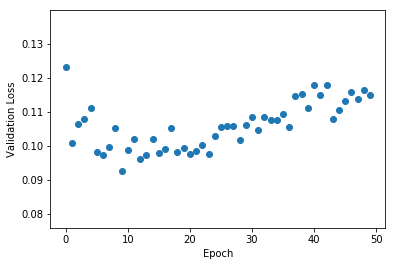

In [18]:
## Diagnosing the learning phase
losses = history.history["val_loss"]
epoch = history.epoch
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.scatter(epoch, losses)
plt.show()

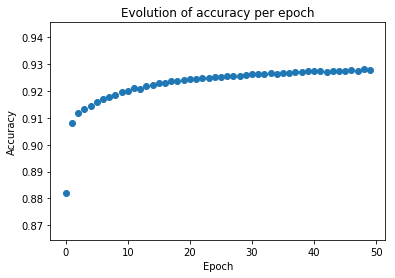

In [19]:
# Plot the accuracies
acc = history.history["acc"]
epoch = history.epoch
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.scatter(epoch, acc)
plt.title('Evolution of accuracy per epoch')
plt.show()

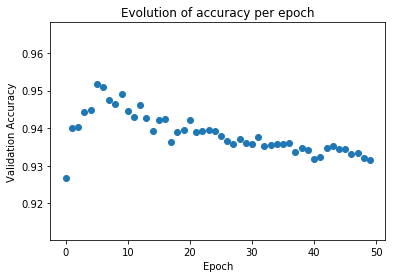

In [20]:
# Plot the accuracies
acc = history.history["val_acc"]
epoch = history.epoch
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.scatter(epoch, acc)
plt.title('Evolution of accuracy per epoch')
plt.show()

In [21]:
training_error = vcnn.evaluate(X_train,Y_train, batch_size = 8192)
validation_error = vcnn.evaluate(X_dev,Y_dev, batch_size = 8192)
print("training error:", training_error)
print("validation error:", validation_error)

100000/100000 [==============================] - 4s 42us/step
training error: [0.15430725483226776, 0.9301419999847412]
validation error: [0.11502105465888977, 0.9316349997520447]


In [22]:
## Saving the weights and the history after 50 epochs
vcnn.save('BasicNN_final.h5')
training = history.history
sio.savemat('BasicNN_history.mat', training)